# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [208]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from matplotlib import pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgamordachova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgamordachova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
df = pd.read_csv('data/nlp/tweet_sentiment_train.csv.zip')

In [36]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [38]:
df[df.text.isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


Є лише один рядок з відсутніми даними, видаляємо його

In [39]:
df.dropna(inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [41]:
df.sentiment.value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

In [42]:
df['text_len'] = df.text.str.len().astype(int)

In [43]:
df.head(-5)

,textID,text,selected_text,sentiment,text_len
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46
2,088c60f138,my boss is bullying me...,bullying me,negative,25
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75
...,...,...,...,...,...
27471,15bb120f57,"i`m defying gravity. and nobody in alll of oz,...","i`m defying gravity. and nobody in alll of oz,...",neutral,106
27472,8f5adc47ec,http://twitpic.com/663vr - Wanted to visit the...,were too late,negative,75
27473,a208770a32,in spoke to you yesterday and u didnt respond...,in spoke to you yesterday and u didnt respond ...,neutral,67
27474,8f14bb2715,So I get up early and I feel good about the da...,I feel good ab,positive,126


Отже, є три таргет класи - neutral, positive, negative

Класи мають приблизно однакову кількість даних

<Axes: >

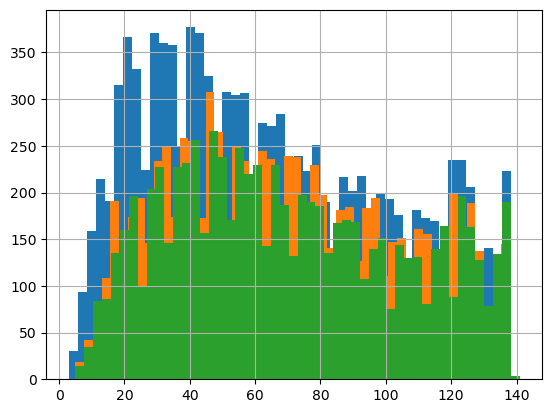

In [91]:
df[df.sentiment=='neutral'].text_len.hist(bins=50)
df[df.sentiment=='positive'].text_len.hist(bins=50)
df[df.sentiment=='negative'].text_len.hist(bins=50)

Розподіл лівоскошений, найбільше текстів з довжиною строки +-40 символів, тобто коротких текстів з 2-3 словами мало, найбільше текстів з приблизно 6-7 словами

Нейтральні пости часто короткі - дуже багато на 20-40 символів

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [57]:
!pip install nltk

In [72]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [73]:
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in english_stopwords]
    return ' '.join(filtered_words)

def stem_tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)]


In [74]:
df['text_tokenized'] = df['text'].apply(remove_stopwords)
df['stemed_tokenized'] = df['text_tokenized'].apply(stem_tokenize)

In [78]:
df[df.sentiment=='negative']

,textID,text,selected_text,sentiment,text_len,text_tokenized,stemed_tokenized
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,Sooo SAD miss San Diego ! ! !,"[sooo, sad, miss, san, diego, !, !, !]"
2,088c60f138,my boss is bullying me...,bullying me,negative,25,boss bullying ...,"[boss, bulli, ...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,interview ! leave alone,"[interview, !, leav, alon]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,"Sons * * * * , ` put releases already bought","[son, *, *, *, *, ,, `, put, releas, alreadi, ..."
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,44,Sharpie running DANGERously low ink,"[sharpi, run, danger, low, ink]"
...,...,...,...,...,...,...,...
27464,e7eecffdc8,rec game....trying not to cry...the pain is to...,breakingg,negative,108,rec game .... trying cry ... pain much .. need...,"[rec, game, ...., tri, cri, ..., pain, much, ...."
27470,778184dff1,lol i know and haha..did you fall asleep?? o...,t bored,negative,79,lol know haha .. fall asleep ? ? get bored sha...,"[lol, know, haha, .., fall, asleep, ?, ?, get,..."
27472,8f5adc47ec,http://twitpic.com/663vr - Wanted to visit the...,were too late,negative,75,http : //twitpic.com/663vr - Wanted visit anim...,"[http, :, //twitpic.com/663vr, -, want, visit,..."
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,77,wish could come see u Denver husband lost job ...,"[wish, could, come, see, u, denver, husband, l..."


На мою думку тут не варто видаляти знаки пунктуації, тому що деякі з них несуть негативний настрій (наприклад *) або позитивний (як комбінація ?! )

In [79]:
df['text_len_stem'] = df.stemed_tokenized.str.len().astype(int)

<Axes: >

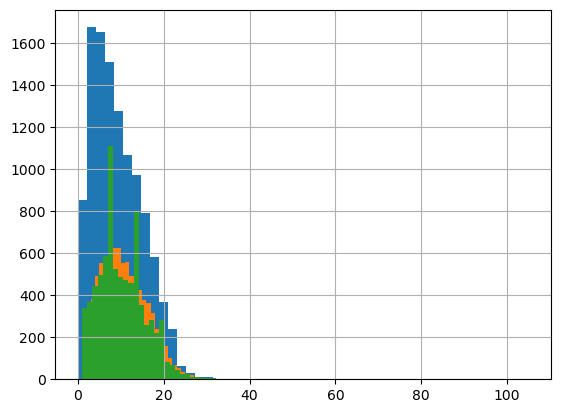

In [90]:
df[df.sentiment=='neutral'].text_len_stem.hist(bins=50)
df[df.sentiment=='positive'].text_len_stem.hist(bins=50)
df[df.sentiment=='negative'].text_len_stem.hist(bins=50)


Після стемізації стала значно меншою довжина рядка

In [118]:
english_stopwords.append('ï¿½')

In [119]:
vectorizer = CountVectorizer(max_features=2700,ngram_range=(1,1), tokenizer=stem_tokenize, stop_words=english_stopwords )
vectorizer.fit(df['text'])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=2700,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function stem_tokenize at 0x16607c720>)

In [ ]:
features_countVector = vectorizer.get_feature_names_out()
transformed_text = vectorizer.transform(df['text'])


In [121]:
transformed_df = pd.DataFrame(data=transformed_text.toarray(), columns=features_countVector)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [131]:
target = (df.sentiment=='negative').astype(int)

In [170]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(transformed_df, target, test_size=0.2, random_state=12, stratify=target)

Train roc_auc_score 0.8024434153900964
Test roc_auc_score 0.7734497540224187
Train f1 0.7356903879193417


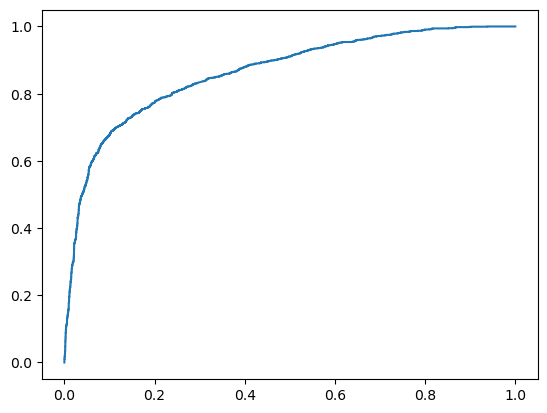

In [171]:
lr_model = LogisticRegression(penalty='l1', random_state=12, solver='liblinear')
lr_model.fit(X_train_bow, y_train_bow)
preds_train = lr_model.predict(X_train_bow)
train_score_lr = roc_auc_score(y_train_bow, preds_train)
preds_test = lr_model.predict(X_test_bow)
pred_test_proba = lr_model.predict_proba(X_test_bow)
test_score_lr = roc_auc_score(y_test_bow, preds_test)
print("Train roc_auc_score {}".format(train_score_lr))
print("Test roc_auc_score {}".format(test_score_lr))
f1_score_lr_train = f1_score(y_train_bow, preds_train)
print("Train f1 {}".format(f1_score_lr_train))
fpr, tpr, thresholds = roc_curve(y_test_bow, pred_test_proba[:, 1])
plt.plot(fpr, tpr)

In [172]:
train_index = X_train_bow.index
test_index = X_test_bow.index

Хороший результат модельки

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [179]:
coefs_lr_df = pd.DataFrame({
    'feature_name':lr_model.feature_names_in_,
    'feature_value':lr_model.coef_[0]
    })

In [181]:
coefs_lr_df.set_index('feature_name')

,feature_value
feature_name,
!,0.013977
#,0.017773
$,0.400166
%,0.397952
&,-0.091581
...,...
zoo,0.000000
{,0.000000
|,0.000000


In [186]:
coefs_lr_df['feature_value'] = coefs_lr_df['feature_value'].apply('abs')

In [207]:
first_300_feat = coefs_lr_df.sort_values('feature_value', ascending=False).feature_name.iloc[:300]
print(first_300_feat.to_numpy())

['glad' 'worst' 'awesom' 'fail' 'terribl' 'amaz' 'suck' 'dammit' 'thank'
 'wtf' 'welcom' 'sad' 'exhaust' 'frustrat' 'hate' 'headach' 'stupid'
 'disappoint' 'curs' 'bore' 'tummi' 'rubbish' 'love' 'lame' 'scari'
 'yucki' 'idiot' 'miss' 'ughh' 'blah' 'cute' 'weird' 'burnt' 'sick'
 'beauti' 'unfortun' 'upset' 'bummer' 'broken' 'depress' 'wors' 'hurt'
 'wrong' '[' 'afraid' 'annoy' 'crappi' 'yummi' 'fantast' 'sorri' 'ignor'
 'poor' 'yum' 'r.i.p' 'awsom' 'wick' 'idol' 'urgh' 'mistak' 'congrat'
 'lone' 'dirti' 'fine' 'stress' 'standard' 'horribl' 'tire' 'hope' 'bruis'
 'clip' 'unfair' 'win' 'weak' 'disgust' 'useless' 'jam' 'nooo' 'hmph'
 'noo' 'damnit' 'mess' 'miser' 'sunburn' 'luckili' 'enjoy' 'metal'
 'jealous' 'hehe' 'twilight' 'great' 'ugh' 'scratch' 'forum' 'pain'
 'stink' 'ach' 'meh' 'shame' 'gorgeous' 'migrain' 'burn' 'cri' 'excit'
 'otherwis' 'fault' 'die' 'lost' 'ador' 'ugli' 'broke' 'cool' 'hard' 'nt'
 'bleh' 'sux' 'bad' 'smile' 'suffer' 'bah' 'kill' 'death' 'mental'
 'instant' 'nice

Деякі слова явно впливають на тип коментаря (наприклад ruin, regret, bless), проте інші на мою думку не дуже - film, wifi, msg

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [211]:
tf_idfVectorizer = TfidfVectorizer(
    tokenizer=stem_tokenize, 
    stop_words=english_stopwords, 
    max_features=2700)
tf_idf_data = tf_idfVectorizer.fit_transform(df['text'])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


In [213]:
features_tfidfVector = tf_idfVectorizer.get_feature_names_out()
transformed_df_tfidf = pd.DataFrame(data=tf_idf_data.toarray(), columns=features_countVector)

In [214]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(transformed_df_tfidf, target, test_size=0.2, random_state=12, stratify=target)

In [215]:
train_index_tfidf = X_train_tfidf.index
test_index_tfidf = X_test_tfidf.index

In [219]:
sum(train_index_tfidf!=train_index) #на всякий випадок перевірка чи дійсно дані розило так само

0

In [220]:
X_train_tfidf

,!,#,$,%,&,',(,),*,+,...,yummi,yup,zero,zombi,zone,zoo,{,|,},~
15257,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4226,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19841,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23719,0.118227,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16329,0.107287,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14613,0.000000,0.0,0.0,0.0,0.0,0.0,0.21204,0.206519,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10256,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train roc_auc_score 0.7770450238035714
Test roc_auc_score 0.7599558936750487
Train f1 0.698510242085661


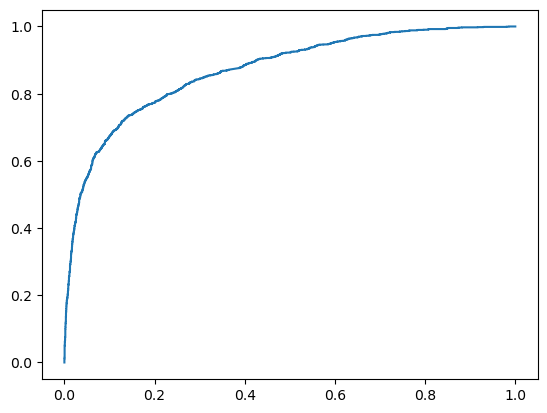

In [238]:
lr_model_tfidf = LogisticRegression(penalty='l1', random_state=12, solver='liblinear')
lr_model_tfidf.fit(X_train_tfidf, y_train_tfidf)
preds_train_tfidf = lr_model_tfidf.predict(X_train_tfidf)
train_score_lr_tfidf = roc_auc_score(y_train_tfidf, preds_train_tfidf)
preds_test_tfidf = lr_model_tfidf.predict(X_test_tfidf)
pred_test_proba_tfidf = lr_model_tfidf.predict_proba(X_test_tfidf)
pred_train_proba_tfidf = lr_model_tfidf.predict_proba(X_train_tfidf)
test_score_lr_tfidf = roc_auc_score(y_test_tfidf, preds_test_tfidf)
print("Train roc_auc_score {}".format(train_score_lr_tfidf))
print("Test roc_auc_score {}".format(test_score_lr_tfidf))
f1_score_lr_train_tfidf = f1_score(y_train_tfidf, preds_train_tfidf)
print("Train f1 {}".format(f1_score_lr_train_tfidf))
fpr_tfidf, tpr_tfidf, thresholds_tfidf = roc_curve(y_test_tfidf, pred_test_proba_tfidf[:, 1])
plt.plot(fpr_tfidf, tpr_tfidf)

На жаль, тут показиники трохи погіршилися

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [243]:
preds_train_tfidf, y_train_tfidf
train_target_comparing_df = pd.DataFrame(
    {
        'target':y_train_tfidf,
        'pred_target':preds_train_tfidf,
        'proba':pred_train_proba_tfidf[:,1]
    }
)

In [244]:
wrong_pred_tfidf = train_target_comparing_df[train_target_comparing_df['target']!=train_target_comparing_df['pred_target']].index

In [247]:
train_target_comparing_df.loc[wrong_pred_tfidf]

,target,pred_target,proba
768,1,0,0.200211
23303,1,0,0.134684
17828,1,0,0.359070
8216,1,0,0.209393
26762,0,1,0.859250
...,...,...,...
19588,0,1,0.812579
8085,1,0,0.495232
21922,1,0,0.198611
10812,1,0,0.187325


In [235]:
df.loc[wrong_pred_tfidf]

,textID,text,selected_text,sentiment,text_len,text_tokenized,stemed_tokenized,text_len_stem
768,49e24a4501,nooooo its raining......had 2 leave the beach,nooooo its raining..,negative,45,nooooo raining ...... 2 leave beach,"[nooooo, rain, ......, 2, leav, beach]",6
23303,34902d475c,To Lisa: Yes I know who ur talking about and y...,he is an ****.,negative,133,Lisa : Yes know ur talking yes * * * * . Dont ...,"[lisa, :, yes, know, ur, talk, yes, *, *, *, *...",21
17828,abfb47f0b8,i have nothing to do except right a eassy due ...,i have nothing to do except right a eassy due ...,negative,71,nothing except right eassy due monday : : [ : ...,"[noth, except, right, eassi, due, monday, :, :...",15
8216,cb9aaf07ff,you should see the Morning Rush Forum`s shout...,Overheat,negative,94,see Morning Rush Forum ` shoutbox . Overheat b...,"[see, morn, rush, forum, `, shoutbox, ., overh...",16
26762,76d03aa370,so my friends are coming to see you on NYC......,.but im on stupid vaca in the stupid cayman is...,neutral,120,friends coming see NYC ... im stupid vaca stup...,"[friend, come, see, nyc, ..., im, stupid, vaca...",16
...,...,...,...,...,...,...,...,...
19588,6f955b0236,- Yeah I know they are **** annoying with tha...,- Yeah I know they are **** annoying with that...,positive,121,"- Yeah know * * * * annoying ... , good promo ...","[-, yeah, know, *, *, *, *, annoy, ..., ,, goo...",16
8085,5da55949f3,I`m bummed...you`re gonna be only 30 minutes ...,I`m bummed.,negative,87,` bummed ... ` gon na 30 minutes Sunday & ` co...,"[`, bum, ..., `, gon, na, 30, minut, sunday, &...",15
21922,832c4aadf3,"A sweltering afternoon no wonder the creepy, s...","creepy, slithering snakes are heading to the c...",negative,135,"sweltering afternoon wonder creepy , slitherin...","[swelter, afternoon, wonder, creepi, ,, slithe...",17
10812,bbad99f9e8,POOOOOOOOR SHEEEEP!!!,POOOOOOOOR SHEEEEP!!!,negative,22,POOOOOOOOR SHEEEEP ! ! !,"[poooooooor, sheeeep, !, !, !]",5


Шляхи покращення класифікації - можливо деяким словам збільшити вагу, використати беггінг, додати довжину тексту як ще одну фічу

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model